## Title

This notebook looks at SP500 returns and its relationship to the VIX - VIX3M

1. Preprocessing and a look at the relationship
2. Working out the VIX3M when its not available

#DO NOT CLEAR OUTPUT AND RUN THE CELLS UNLESS YOU HAVE YOUR OWN SOURCE OF DATA. 

# Background

What is the SP500? 

Roughly speaking, it is the largest 500 stocks by market capitalisation in the US. 

https://www.spglobal.com/spdji/en/indices/equity/sp-500/

What is the VIX?

https://www.cboe.com/tradable_products/vix/

Essentially, the VIX measures the implied volatility embedded in the SPX options, which are based on the SP500 index. 

VIX measures a 30 day horizon.

The VIX3M repeats the same methodology for VIX, but on a 3 month basis. 

In essence, this notebook will look at the relationship between the VIX and VIX3M, which are derived from SPX options, and the effect on the underlying SP500.

Why are we interested in this?

In general, if the VIX has higher variance than VIX3M, the only logical explanation is that some near term event which will cause significant volatility exists. However, once it happens, volatility is expected to reduce. So we would expect some effect on forward 1 day returns on the SP500 when the VIX is greater than VIX3M.


# Section 1: Preprocessing and existing datasets

In [1]:
# import the libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import stats

pd.set_option('display.max_columns', None)


First, the SP500 index data. You can download this from yahoo finance, or just use the CSV present in the repo

https://sg.finance.yahoo.com/quote/%5EGSPC/history/

For the purposes of this notebook, the data will terminate on 31/12/2023

In [2]:
act_sp500 = pd.read_csv('spoos.csv')

act_sp500.head()

,Year,Month,Day,Open,High,Low,Close*,Adj Close**,Volume
0,1957,3,4,44.060001,44.060001,44.060001,44.060001,44.060001,1890000
1,1957,3,5,44.220001,44.220001,44.220001,44.220001,44.220001,1860000
2,1957,3,6,44.230000,44.230000,44.230000,44.230000,44.230000,1840000
3,1957,3,7,44.209999,44.209999,44.209999,44.209999,44.209999,1830000
4,1957,3,8,44.070000,44.070000,44.070000,44.070000,44.070000,1630000


Some of the pre-processing will need to be adjusted if you have your own dataset.
The broad structure of what your dataframe should look like will be given.

In [3]:
act_sp500.dropna(inplace=True)
act_sp500['date_dt'] = pd.to_datetime(dict(year=act_sp500.Year, month=act_sp500.Month, day=act_sp500.Day))
act_sp500.sort_values('date_dt', inplace=True)


In [4]:
# next, get the forward changes, drop the unnecessary columns

act_sp500["change"] = act_sp500["Close*"].pct_change()
act_sp500['change'] = act_sp500['change'].shift(-1)
act_sp500['spclose'] = act_sp500['Close*']
act_sp500['log_change'] = np.log(act_sp500['spclose'] / act_sp500['spclose'].shift(1)) # this will be used for realised vol
act_sp500.drop(columns= ["Year",'Month','Day','Open','High','Low','Close*','Adj Close**','Volume'],inplace=True)


This is all that we need for the model

In [5]:
act_sp500.head()

,date_dt,change,spclose,log_change
0,1957-03-04,0.003631,44.060001,NaN
1,1957-03-05,0.000226,44.220001,0.003625
2,1957-03-06,-0.000452,44.230000,0.000226
3,1957-03-07,-0.003167,44.209999,-0.000452
4,1957-03-08,-0.006580,44.070000,-0.003172


A couple of custom indicators to show the local lows and highs in the SP500, as well as the realised volatility in the markets on a 1 month and 3 month basis.

In [6]:
local_range = 10
act_sp500['sp_local_high_bac'] = act_sp500.spclose.rolling(local_range).max()
act_sp500.sort_values('date_dt',inplace= True, ascending= False)
act_sp500['sp_local_high_for'] = act_sp500.spclose.rolling(local_range).max()
act_sp500.sort_values('date_dt',inplace= True, ascending= True)
act_sp500['sp_local_high'] = np.where( (act_sp500['spclose'] >= act_sp500['sp_local_high_bac']) & (act_sp500['spclose'] >= act_sp500['sp_local_high_for']),1,0)


In [7]:
local_range = 10
act_sp500['sp_local_low_bac'] = act_sp500.spclose.rolling(local_range).min()
act_sp500.sort_values('date_dt',inplace= True, ascending= False)
act_sp500['sp_local_low_for'] = act_sp500.spclose.rolling(local_range).min()
act_sp500.sort_values('date_dt',inplace= True, ascending= True)
act_sp500['sp_local_low'] = np.where( (act_sp500['spclose'] <= act_sp500['sp_local_low_bac']) & (act_sp500['spclose'] <= act_sp500['sp_local_low_for']),1,0)


In [8]:
act_sp500['realised_var'] = act_sp500['log_change'].rolling(21, min_periods=1).apply(lambda x: np.sum(x**2))
act_sp500['realised_vix'] = np.sqrt((252 / 21) * act_sp500['realised_var']) * 100

act_sp500['realised_var_3m'] = act_sp500['log_change'].rolling(63, min_periods=1).apply(lambda x: np.sum(x**2))
act_sp500['realised_vix_3m'] = np.sqrt((252 / 63) * act_sp500['realised_var_3m']) * 100


In [9]:
act_sp500.drop(columns= ["realised_var",'realised_var_3m','sp_local_high_bac','sp_local_low_for','sp_local_low_bac','sp_local_high_for'],inplace=True)
act_sp500.head()

,date_dt,change,spclose,log_change,sp_local_high,sp_local_low,realised_vix,realised_vix_3m
0,1957-03-04,0.003631,44.060001,NaN,0,0,NaN,NaN
1,1957-03-05,0.000226,44.220001,0.003625,0,0,1.255679,0.724967
2,1957-03-06,-0.000452,44.230000,0.000226,0,0,1.258120,0.726376
3,1957-03-07,-0.003167,44.209999,-0.000452,0,0,1.267839,0.731987
4,1957-03-08,-0.006580,44.070000,-0.003172,0,0,1.677671,0.968604


This is what the results visualised look like, for a small subset of the time period

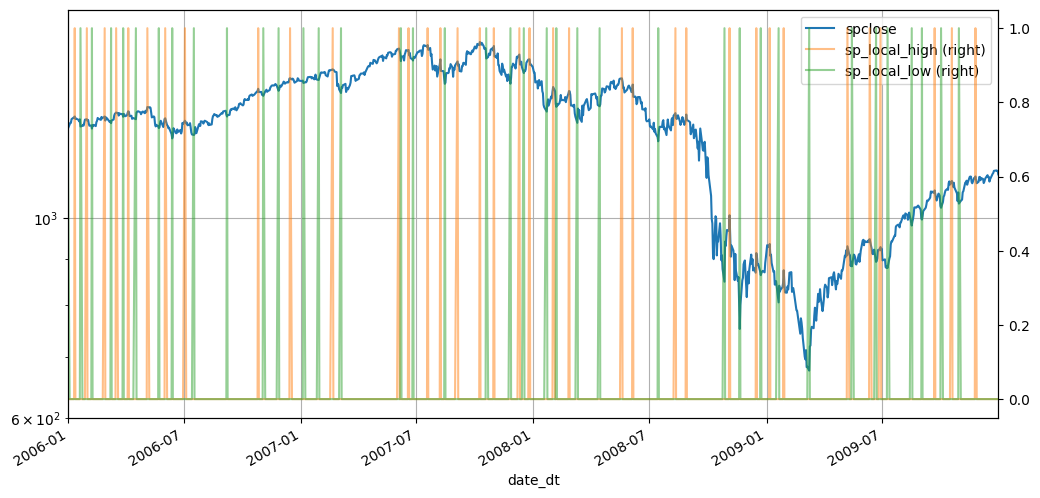

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
act_sp500.plot('date_dt', 'spclose', logy=True, grid=True, ax=ax)
act_sp500.plot('date_dt', ['sp_local_high', 'sp_local_low'], secondary_y=True, ax=ax, alpha=0.5)
start_date = pd.Timestamp('2006-01-01')
end_date = pd.Timestamp('2009-12-31')
ax.set_xlim(start_date, end_date)
ax.set_ylim(600, 1700)
plt.show()

Now, we add in the VIX and VIX3M data sources.

First, import the files. You can use the files provided in the repo, or download them from the CBOE's website. 

https://www.cboe.com/tradable_products/vix/vix_historical_data/

The preprocessing is based on the files in the repo. The end result will be shown so that you can adopt them for the CBOE's download CSV.

In [11]:
act_vix = pd.read_csv('VIX.csv')
act_vix['date'] = act_vix[["year","month","day"]].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

act_vix.dropna(inplace=True)
act_vix['date_dt'] = act_vix['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
act_vix.drop(columns= ["year",'month','day','open','high','low','date'],inplace=True)

act_vix = act_vix.rename(columns={'close': 'VIX_close'})

In [12]:
act_vix_3m = pd.read_csv('VIX3M.csv')
act_vix_3m['date'] = act_vix_3m[["Year","Month","Day"]].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
act_vix_3m.dropna(inplace=True)
act_vix_3m['date_dt'] = act_vix_3m['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
act_vix_3m.drop(columns= ["Year",'Month','Day','Open','High','Low','date','Adj Close','Volume'],inplace=True)

act_vix_3m = act_vix_3m.rename(columns={'Close': 'VIX_3M_close'})

In [13]:
act_vix_merge = pd.merge(act_vix_3m,act_vix, on = 'date_dt')


In [14]:
act_vix_merge.head()

,VIX_3M_close,date_dt,VIX_close
0,17.219999,2006-07-18,17.74
1,15.600000,2006-07-19,15.55
2,16.309999,2006-07-20,16.21
3,17.040001,2006-07-21,17.40
4,15.410000,2006-07-24,14.98


Time to merge the Closing values of VIX, VIX3M into our SP500 database.

We had a column for percentage change because we will be using geometric averages later. 



In [15]:
merged_df = pd.merge(act_sp500,act_vix_merge, on = 'date_dt')
merged_df['percent_change'] = merged_df['change'] + 1
merged_df.info()

# some columns can be dropped but 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4136 entries, 0 to 4135
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date_dt          4136 non-null   datetime64[ns]
 1   change           4136 non-null   float64       
 2   spclose          4136 non-null   float64       
 3   log_change       4136 non-null   float64       
 4   sp_local_high    4136 non-null   int32         
 5   sp_local_low     4136 non-null   int32         
 6   realised_vix     4136 non-null   float64       
 7   realised_vix_3m  4136 non-null   float64       
 8   VIX_3M_close     4136 non-null   float64       
 9   VIX_close        4136 non-null   float64       
 10  percent_change   4136 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int32(2)
memory usage: 323.3 KB


After that, let us set a simple binary comparison. If VIX is greater than VIX3M, declare the VIX curve as inverted. Else not.

To analyse this, just make a groupby

In [16]:
merged_df['inverted'] = np.where(merged_df['VIX_close'] > merged_df['VIX_3M_close'], 1, 0)
merged_gby = merged_df.groupby('inverted')


A quick visualisation of the inversion periods versus the underlying

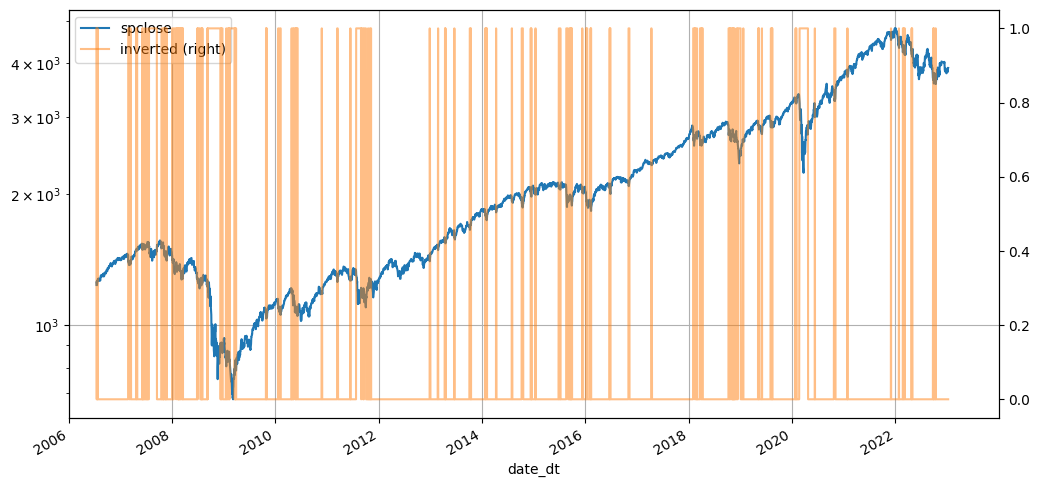

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
merged_df.plot('date_dt', 'spclose', logy = True, grid = True, ax=ax)
merged_df.plot('date_dt', ['inverted'], secondary_y=True, ax=ax, alpha = 0.5)
start_date = pd.Timestamp('2006-01-01')
end_date = pd.Timestamp('2023-12-31')
ax.set_xlim(start_date, end_date)

plt.show()


After that, a quick look at the stats

In [18]:
merged_gby['sp_local_low'].value_counts()
merged_gby['sp_local_high'].value_counts()

inverted  sp_local_high
0         0                3511
          1                 120
1         0                 502
          1                   3
Name: count, dtype: int64

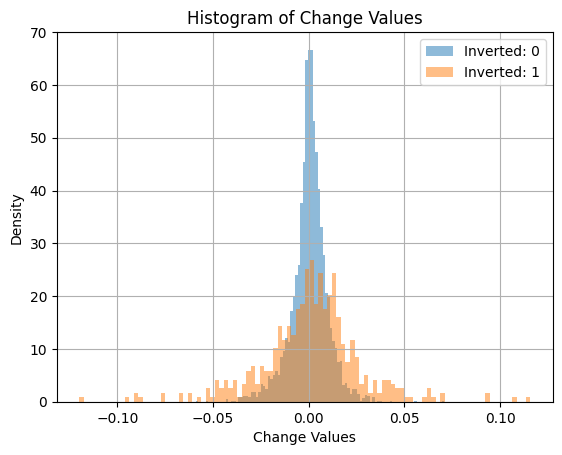

In [21]:
#merged_gby.change.hist(density = True, grid=True, bins =100, alpha = 0.5, label='Change Histogram')

fig, ax = plt.subplots()

for name, group in merged_gby:
    group['change'].hist(density=True, grid=True, bins=100, alpha=0.5, label=f'Inverted: {name}', ax=ax)

# Customize your plot (labels, title, etc.)
ax.set_xlabel('Change Values')
ax.set_ylabel('Density')
ax.set_title('Histogram of Change Values')
ax.legend()

# Show the plot
plt.show()

In [22]:
merged_gby['percent_change'].apply(stats.gmean) - 1 


inverted
0    0.000254
1    0.000479
Name: percent_change, dtype: float64

In [23]:
merged_gby['change'].mean()

inverted
0    0.000300
1    0.000824
Name: change, dtype: float64

In [24]:
merged_gby['change'].var()

inverted
0    0.000092
1    0.000689
Name: change, dtype: float64

In [23]:
merged_gby['change'].skew()

inverted
0   -0.336756
1   -0.170297
Name: change, dtype: float64

Conclusion at the end of part 1:

- When VIX is greater that VIX3M, the 1 day forward returns have a radically different distribution.
- The inversions tend to appear in times of market stress, ie the market has gone down from its local high
- Local lows tend to occur during periods of inversion

However, all we have from the CBOE is data from 2006 onwards for VIX3M, whereas the VIX is available from 1990 onwards.

In order to make sure that our model is stationary, we will need to compute the VIX3M from 1990-2006.

We could go back even further, but market structure (eg SP100 options vs SP500 options, listing, liquidity) is different pre 1990

# Section 2: Using options to price the VIX

You need to purchase the options price data from a third party

This will walk you through the VIX process


Import the libraries

In [25]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats

pd.set_option('display.max_columns', None)

Step 1: import the dataframe. You need the option prices as well as rates matrix.

Rates Matrix can be downloaded from the US treasury website:
https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2024

Options Prices can be bought from third party. I got mine from DeltaNeutral/historical option prices. 

Depending on your dataset, the preprocessing part will be different. Nonetheless, the end dataset will be present so that you can use the functions later on.

In [26]:
# this contains the option prices
df = pd.read_csv('SPX_1990.csv')

df.head()

,underlying,underlying_last,exchange,optionroot,optionext,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,optionalias,IVBid,IVAsk
0,SPX,359.69,*,SPX900120C00225000,NaN,call,01/20/1990,01/02/1990,225,0.000,135.5,135.5,0,820,0.0922,1.0000,0.0000,-18.7690,0.0000,SPX900120C00225000,0.0000,0.0000
1,SPX,359.69,*,SPX900120P00225000,NaN,put,01/20/1990,01/02/1990,225,0.000,0.0,0.1,0,2016,0.3122,0.0000,0.0000,0.0000,0.0000,SPX900120P00225000,0.0000,0.8615
2,SPX,359.69,*,SPX900120C00320000,NaN,call,01/20/1990,01/02/1990,320,0.000,40.9,40.9,0,1088,0.0922,1.0000,0.0000,-26.6936,0.0000,SPX900120C00320000,0.0000,0.0000
3,SPX,359.69,A,SPX900120P00320000,NaN,put,01/20/1990,01/02/1990,320,0.313,0.3,0.4,5,2622,0.3122,-0.0351,0.0032,-18.8547,6.0662,SPX900120P00320000,0.3039,0.3204
4,SPX,359.69,*,SPX900120C00325000,NaN,call,01/20/1990,01/02/1990,325,0.000,35.9,35.9,0,1252,0.0922,1.0000,0.0000,-27.1107,0.0000,SPX900120C00325000,0.0000,0.0000


In [27]:
# this contains the rates
rates = pd.read_csv('rates_1990.csv')

rates.head()

,Date,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,30 Yr
0,12/31/1990,6.63,6.73,6.82,7.15,7.40,7.68,8.00,8.08,8.26
1,12/28/1990,6.64,6.85,6.91,7.25,7.48,7.78,8.08,8.14,8.31
2,12/27/1990,6.67,6.91,6.94,7.25,7.46,7.75,8.03,8.11,8.25
3,12/26/1990,6.68,6.91,6.94,7.27,7.50,7.78,8.07,8.15,8.30
4,12/24/1990,6.73,6.95,6.99,7.35,7.53,7.84,8.12,8.20,8.36


Now it is time to do the data manipulation to get the columns needed for the scripts to calculate

What we need is 
- the time to expiry in minutes (take 3 Mo for all, since overnight rates, 1 Mo are not readily available)
- time value of money til expiry
- midpoint prices of the options (BID-ASK)

What we drop - end of quarter options, since VIX only uses monthly SPX and weekly SPXW. You may need additional steps if your dataset is tackling periods when SPXW is being used on a regular basis


In [28]:
def do_process_df_new(df,rates):
    df['quotedate_dt'] = df['quotedate'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'))
    rates['quotedate_dt'] = rates['Date'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'))
    df = pd.merge(df, rates[['quotedate_dt', '3 Mo']], on='quotedate_dt', how='left')
    df['3 Mo'] = df['3 Mo'].ffill()
    df['quotedate_dt'] += pd.Timedelta(hours=16, minutes=00)
    df['expiration_dt'] = df['expiration'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'))
    df['expiration_dt'] += pd.Timedelta(hours=9, minutes=30)
    # VIX takes absolute time to expiry. however expiry is 0930 AM for most of the SPX (not SPXW)
    df['time_expiry'] = df["expiration_dt"] - df["quotedate_dt"]
    df['time_value'] = np.exp(df['time_expiry'] / np.timedelta64(1, 'm') / 525600 * df['3 Mo'] / 100)
    df['price'] = 0.5 * (df['bid'] + df['ask'])
    df.drop(columns=['underlying', ' exchange', 'optionext','gamma','theta','vega','volume','openinterest','optionalias','optionroot'], inplace=True)

    df2 = df[df['expiration_dt'].dt.day <= 28].copy()
    return df2


In [29]:
df = do_process_df_new(df,rates)
df.head()
# many more columns could be dropped. But some of the greeks are relevant for other analysis (not in this notebook)

,underlying_last,type,expiration,quotedate,strike,last,bid,ask,impliedvol,delta,IVBid,IVAsk,quotedate_dt,3 Mo,expiration_dt,time_expiry,time_value,price
0,359.69,call,01/20/1990,01/02/1990,225,0.000,135.5,135.5,0.0922,1.0000,0.0000,0.0000,1990-01-02 16:00:00,7.83,1990-01-20 09:30:00,17 days 17:30:00,1.003811,135.50
1,359.69,put,01/20/1990,01/02/1990,225,0.000,0.0,0.1,0.3122,0.0000,0.0000,0.8615,1990-01-02 16:00:00,7.83,1990-01-20 09:30:00,17 days 17:30:00,1.003811,0.05
2,359.69,call,01/20/1990,01/02/1990,320,0.000,40.9,40.9,0.0922,1.0000,0.0000,0.0000,1990-01-02 16:00:00,7.83,1990-01-20 09:30:00,17 days 17:30:00,1.003811,40.90
3,359.69,put,01/20/1990,01/02/1990,320,0.313,0.3,0.4,0.3122,-0.0351,0.3039,0.3204,1990-01-02 16:00:00,7.83,1990-01-20 09:30:00,17 days 17:30:00,1.003811,0.35
4,359.69,call,01/20/1990,01/02/1990,325,0.000,35.9,35.9,0.0922,1.0000,0.0000,0.0000,1990-01-02 16:00:00,7.83,1990-01-20 09:30:00,17 days 17:30:00,1.003811,35.90


Now we do the full calculation.

The end result is that for every day, we will store the data in a dictionary  
{  
actual_date: [ [expiry_date_1, Variance_1], [expiry_date_2, Variance_2],....,[expiry_date_n, Variance_n]],  
.....  
final_date:[ [expiry_date_1, Variance_1], [expiry_date_2, Variance_2],....,[expiry_date_n, Variance_n]]  
}

This way, we can do plotting for any VIX date we want afterwards

A series of functions will be used. It follows broadly the logic listed in the VIX methodology Paper

https://cdn.cboe.com/api/global/us_indices/governance/VIX_Methodology.pdf

Supplementary data is listed here

https://cdn.cboe.com/api/global/us_indices/governance/Cboe_Volatility_Index_Mathematics_Methodology.pdf

Within the code block, the deviations and justifications are listed down

In [30]:
pro_dict = {}

In [31]:
# this function iterates over all the actual dates, and then expiry dates within the specific date.
# it gets the correct strike and variance value from other functions.

def get_repl_vix_new(df, pro_dict):

    quote_date_list = df.quotedate_dt.unique()
    for entry in quote_date_list:
        temp_df = df[df["quotedate_dt"] == entry].copy()
        exp_date_list = temp_df.expiration_dt.unique()
        list_iv_pro = []
        for entry2 in exp_date_list:
            temp_df_2 = temp_df[temp_df["expiration_dt"] == entry2].copy()
            #if len(temp_df_2) < 20:
            if len(temp_df_2[temp_df_2['bid'] > 0 ]) < 20:
                pass 
                # we need at least 3 different strikes (x2 = 6), else we cannot have an above and below
                # however, we do not screen for 0 bids, which will be eliminated in the calculation
                # so it is better to place it at a higher number, so that the variance calculation is better
            else:
                try:
                    time_to_expiry, forward_price, closest_strike , pivot_strike= get_forward_strike(temp_df_2)

                    var_weighted = get_var_weighted(temp_df_2, closest_strike, time_to_expiry)
                    
                    #the actual formula calls for the forward prices to be subtracted. 
                    # however the actual value is so low, the increase in compute is not worth it

                    if np.isnan(var_weighted) != True:
                        if var_weighted < 0.001 or var_weighted > 1:
                            pass
                        else:
                            list_iv_pro.append([time_to_expiry,var_weighted])

                except:
                    pass
                    #print(entry, entry2) # this is purely for debugging 

            del temp_df_2

        pro_dict[entry] = list_iv_pro
        del temp_df
    return pro_dict



In [32]:
# this function gets the correct forward strike and closest strike to use

def get_forward_strike(temp_df_2):

    time_to_expiry = temp_df_2["time_expiry"].iloc[0] / np.timedelta64(1, 'm')

    # get the pivot call/put
    # filter those without bid, and ned both put + call
    temp_df_3 = temp_df_2[temp_df_2['bid'] > 0].copy()
    df2 = temp_df_3.groupby('strike').filter(lambda x: len(x) > 1).copy()

    temp_gb = df2.groupby('strike')
    temp_gb_2 = temp_gb['price'].max() - temp_gb['price'].min()
    pivot_strike = temp_gb_2.idxmin()
    # pivot strike found, now get the forward price and closest lower strike 
    df2 = df2[df2['strike'] == pivot_strike]
    price_call = df2[(df2['strike'] == pivot_strike) & (df2['type'] == 'call')].iloc[0]['price']
    price_put = df2[(df2['strike'] == pivot_strike) & (df2['type'] == 'put')].iloc[0]['price']
    forward_price = pivot_strike + df2['time_value'].iloc[0] * (price_call - price_put)
    closest_strike = temp_df_2[temp_df_2['strike'] <= forward_price]['strike'].max()

    del df2, temp_gb, temp_gb_2, temp_df_3

    return time_to_expiry, forward_price, closest_strike, pivot_strike


In [33]:
# this function gets the variance once the closest strike has been identified
def get_var_weighted(temp_df_2, closest_strike, time_to_expiry):
    df3 = temp_df_2[temp_df_2['type'] == 'call'].copy()
    df4 = temp_df_2[temp_df_2['type'] == 'put'].copy()
    df3 = df3[df3['strike'] >= closest_strike]
    df4 = df4[df4['strike'] <= closest_strike]

    """
    # the VIX calculation calls for consecutive zeros to be dropped
    # however, it adds a lot of compute time for little gain since these are infrequent
    
    consecutive_zeros_index_put = df4.index[(df4['bid'] == 0) & (df4['bid'].shift(1) == 0)].max()

    consecutive_zeros_index_call = df3.index[(df3['bid'] == 0) & (df3['bid'].shift(1) == 0)].min()

    if np.isnan(consecutive_zeros_index_put) != True:
        df4 = df4.iloc[consecutive_zeros_index_put:]

    if np.isnan(consecutive_zeros_index_call) != True:
        df3 = df3.iloc[:consecutive_zeros_index_call]

    """
    # drop all zeros
    df3 = df3[df3['bid'] > 0]
    df4 = df4[df4['bid'] > 0]
    
    # the VIX calculation also calls for df3 and df4 to be greater than 1. If so, the VIX calculation fails. 
    # however I didnt notice much difference. Right now it is rigged to return 0, as the other function will reject it
    
    if len(df3) == 0 or len(df4) == 0:
        
        return 0
    
    else:

        df5 = pd.concat([df3, df4])
        df5.sort_values(by='strike', inplace=True)
        strike_diff = get_diff(df5)
    
        df5['breathe'] = strike_diff
        df5['contri'] = df5['price'] * df5['breathe'] / (df5['strike'] ** 2) * df['time_value']
    
        var_weighted = df5['contri'].sum() / (time_to_expiry / 525600) * 2
        del df3, df4, df5
        return var_weighted


In [34]:
# this function gets the breathe to multiply. For ease of calculation, the put/call average for the closest strike
# is instead done by setting the value to be half. This speeds up the calculation

def get_diff(df):

    strike_diff = []

    for i in range(len(df)):

        if i == 0:
            diff = df.iloc[i+1]['strike'] - df.iloc[i]['strike']
            if df.iloc[i]['strike'] == df.iloc[i + 1]['strike']:
                diff /= 2
        elif i == len(df)-1:
            diff = df.iloc[i]['strike'] - df.iloc[i-1]['strike']
            if df.iloc[i]['strike'] == df.iloc[i - 1]['strike']:
                diff /= 2
        else:
            if df.iloc[i]['strike'] == df.iloc[i-1]['strike']:
                upper_value = df.iloc[i-2]['strike']
            else:
                upper_value = df.iloc[i-1]['strike']
            if df.iloc[i]['strike'] == df.iloc[i+1]['strike']:
                lower_value = df.iloc[i + 2]['strike']
            else:
                lower_value = df.iloc[i + 1]['strike']

            diff = (- upper_value + lower_value) / 2

            if df.iloc[i]['strike'] == df.iloc[i - 1]['strike'] or df.iloc[i]['strike'] == df.iloc[i + 1]['strike']:
                diff /= 2
        #print(diff)
        strike_diff.append(diff)

    return strike_diff


That is the end of the functions to process the option prices into VIX (which is a variance swap translated into volatility)

Now here are the functions to plot VIX and VIX3M

In [39]:
def plot_graph_rep_var(pro_dict):
    
    # if the VIX cannot be calculated, use the previous value
    
    x_values = []
    y_values = []
    for entry in pro_dict.keys():
        if pro_dict[entry] != []:
            x_values.append(entry)
            #print(pro_dict[entry])
            closest_above, closest_below = get_var_values(43200,pro_dict[entry])
            inter_value = get_var_pol(closest_above, closest_below,43200)
            y_values.append(inter_value)
            last_value = inter_value
        else:
            x_values.append(entry)
            y_values.append(last_value)
    plt.figure(figsize=(10, 6))
    plt.ylim(0, 50)

    # this code block does xlim if needed.
    #date_start = pd.Timestamp('1998-01-01')
    #date_end = pd.Timestamp('1999-01-01')

    # Set x-axis limits between 2008 and 2009
    #plt.xlim(mdates.date2num(date_start), mdates.date2num(date_end))

    ax1 = plt.plot(x_values,y_values, label = 'VIX')

    vix90_values = []
    vix90_y_values = []
    for entry in pro_dict.keys():
        if pro_dict[entry] != []:
            vix90_values.append(entry)
            closest_above, closest_below = get_var_values(93*24*60,pro_dict[entry])
            inter_value = get_var_pol(closest_above, closest_below,93*24*60)
            vix90_y_values.append(inter_value)
            last_value = inter_value
        else:
            x_values.append(entry)
            y_values.append(last_value)
    plt.plot(vix90_values,vix90_y_values, label = 'VIX3M')
    plt.grid()
    #plt.ylim(0,1)
    plt.legend()
    plt.show()


In [63]:
# this functions are needed for the plotting
def get_var_pol(upper,lower, value = 43200):

    lower_date, lower_value = lower[0], lower[1]
    upper_date, upper_value = upper[0], upper[1]
    try:
        vol_index = lower_date / 525600 * lower_value * (upper_date - value) / (upper_date - lower_date)
        vol_index += upper_date / 525600 * upper_value * (value - lower_date) / (upper_date - lower_date)
        vol_index *= 525600/value
        vol_index = 100 * (vol_index ** 0.5)
    except:
        #print(upper,lower) #debug only
        vol_index = 100 * (lower_value ** 0.5)
    return vol_index


def get_var_values(test_value,list_input, minimum_value = 10080):
    try:
        # Get values below and above the target date
        below_values = [[date, value] for date, value in list_input if date <= test_value and date > minimum_value]
        above_values = [[date, value] for date, value in list_input if date >= test_value and date > minimum_value]

        # If there are values below the target date, select the closest one, otherwise select the two closest above
        if below_values:
            closest_below = max(below_values, key=lambda x: x[0])
            closest_above = min(above_values, key=lambda x: x[0])
        else:
            closest_below = above_values[0]
            closest_above = above_values[1]
        return closest_above, closest_below

    except:
        #print('ERROR', list_input)
        return list_input[0], list_input[0]


Lets visualise the results for the year 1990

In [40]:
pro_dict= get_repl_vix_new(df, pro_dict)

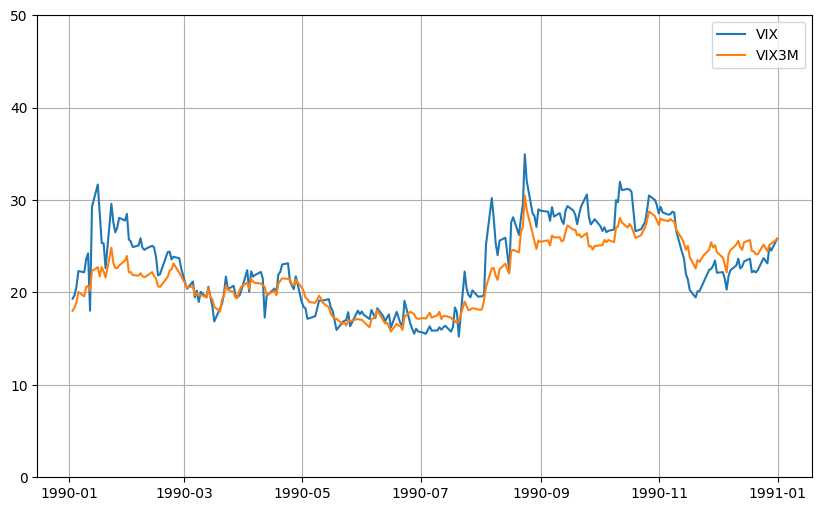

In [41]:
plot_graph_rep_var(pro_dict)

Time to compare to the VIX and VIX3M

In [42]:
def mez_dict_var(pro_dict, num_days):
    
    # if the VIX cannot be calculated, use the previous value
    mez_dict = {}
    for entry in pro_dict.keys():
        date_only = entry.date()
        try:
            closest_above, closest_below = get_var_values(num_days, pro_dict[entry])
            inter_value = get_var_pol(closest_above, closest_below, num_days)
            mez_dict[date_only] = inter_value
            last_value = inter_value
        except:
            mez_dict[date_only] = last_value
    return mez_dict


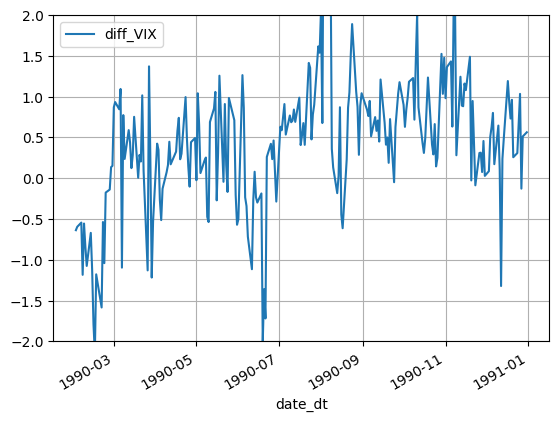

<Figure size 1200x600 with 0 Axes>

In [43]:
temp = mez_dict_var(pro_dict, 43200)

act_vix['cal_VIX']= act_vix['date_dt'].map(temp)
act_vix['diff_VIX'] = act_vix['VIX_close'] - act_vix['cal_VIX']

act_vix.plot('date_dt','diff_VIX',grid=True)
plt.ylim(-2,2)

# if you want to set xlims
#date_start = pd.Timestamp('2008-01-01')
#date_end = pd.Timestamp('2009-01-01')

# Set x-axis limits between 2008 and 2009
#plt.xlim(mdates.date2num(date_start), mdates.date2num(date_end))

plt.figure(figsize=(12,6))
plt.show()

The error is kind of large, but with basis towards overestimating higher values of VIX and underestimating lower values of VIX

This is down to strike selection and the near and far dates used to interpolate.

It is not clear from the VIX white paper whether small chains are used, or how the logic goes.

After 1998 though, the errors drastically go down. Post 2002, it is way more closer to the VIX

also every 30 days, VIX is decided based on SOQ. This data is not present. 

Lets compare to the VIX3M actual data.

In [44]:
df = pd.read_csv('SPX_2006.csv')
rates = pd.read_csv('rates_2006.csv')
df = do_process_df_new(df,rates)
pro_dict= get_repl_vix_new(df, pro_dict)

df = pd.read_csv('SPX_2007.csv')
rates = pd.read_csv('rates_2007.csv')
df = do_process_df_new(df,rates)
pro_dict= get_repl_vix_new(df, pro_dict)

df = pd.read_csv('SPX_2008.csv')
rates = pd.read_csv('rates_2008.csv')
df = do_process_df_new(df,rates)
pro_dict= get_repl_vix_new(df, pro_dict)


In [45]:
temp_2 = mez_dict_var(pro_dict, 93*24*60)

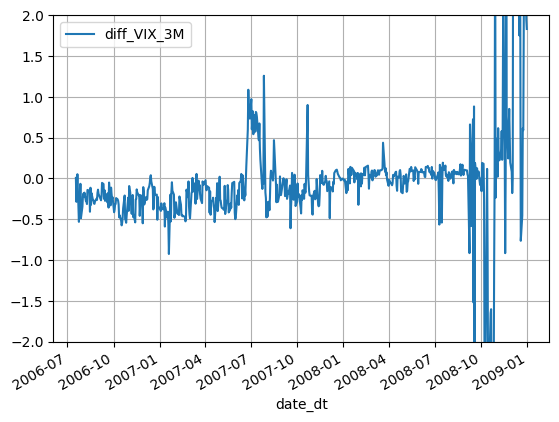

<Figure size 1200x600 with 0 Axes>

In [46]:
# this code block does the VIX3M

act_vix_3m['cal_VIX_3M']= act_vix_3m['date_dt'].map(temp_2)

act_vix_3m['diff_VIX_3M'] = act_vix_3m['VIX_3M_close'] - act_vix_3m['cal_VIX_3M']

act_vix_3m.plot('date_dt','diff_VIX_3M',grid=True)
plt.ylim(-2,2)

# If you want to put xlim for some reason
#date_start = pd.Timestamp('2008-01-01')
#date_end = pd.Timestamp('2009-01-01')

# Set x-axis limits between 2008 and 2009
#plt.xlim(mdates.date2num(date_start), mdates.date2num(date_end))

plt.figure(figsize=(12,6))
plt.show()


The key areas of discrepancy are due to the timing nature of the options

VIX is 1615, whereas the dataset is 1600 for pricing timing

So if there are huge changes in the prices, the selected closest strike will be different

This has a huge effect on the Variance calculated

For the period in the GFC, this is expectionally so. 

This whole script runs from 1991 -2006. depending on your data source. It is commented out, and broken down year by year (as the script takes longer and longer to run as the years go by)

In [65]:
"""

df = pd.read_csv('SPX_1991.csv')
rates = pd.read_csv('rates_1991.csv')
df = do_process_df_new(df,rates)
pro_dict= get_repl_vix_new(df, pro_dict)
#plot_graph_rep_var(pro_dict)

df = pd.read_csv('SPX_1992.csv')
rates = pd.read_csv('rates_1992.csv')
df = do_process_df_new(df,rates)
pro_dict= get_repl_vix_new(df, pro_dict)
#plot_graph_rep_var(pro_dict)

df = pd.read_csv('SPX_1993.csv')
rates = pd.read_csv('rates_1993.csv')
df = do_process_df_new(df,rates)
pro_dict= get_repl_vix_new(df, pro_dict)
#plot_graph_rep_var(pro_dict)

df = pd.read_csv('SPX_1994.csv')
rates = pd.read_csv('rates_1994.csv')
df = do_process_df_new(df,rates)
pro_dict= get_repl_vix_new(df, pro_dict)
#plot_graph_rep_var(pro_dict)

df = pd.read_csv('SPX_1995.csv')
rates = pd.read_csv('rates_1995.csv')
df = do_process_df_new(df,rates)
pro_dict= get_repl_vix_new(df, pro_dict)
#plot_graph_rep_var(pro_dict)

df = pd.read_csv('SPX_1996.csv')
rates = pd.read_csv('rates_1996.csv')
df = do_process_df_new(df,rates)
pro_dict= get_repl_vix_new(df, pro_dict)
#plot_graph_rep_var(pro_dict)

df = pd.read_csv('SPX_1997.csv')
rates = pd.read_csv('rates_1997.csv')
df = do_process_df_new(df,rates)
pro_dict= get_repl_vix_new(df, pro_dict)
#plot_graph_rep_var(pro_dict)

df = pd.read_csv('SPX_1998.csv')
rates = pd.read_csv('rates_1998.csv')
df = do_process_df_new(df,rates)
pro_dict= get_repl_vix_new(df, pro_dict)
#plot_graph_rep_var(pro_dict)

df = pd.read_csv('SPX_1999.csv')
rates = pd.read_csv('rates_1999.csv')
df = do_process_df_new(df,rates)
pro_dict= get_repl_vix_new(df, pro_dict)
#plot_graph_rep_var(pro_dict)

df = pd.read_csv('SPX_2000.csv')
rates = pd.read_csv('rates_2000.csv')
df = do_process_df_new(df,rates)
pro_dict= get_repl_vix_new(df, pro_dict)
#plot_graph_rep_var(pro_dict)

df = pd.read_csv('SPX_2001.csv')
rates = pd.read_csv('rates_2001.csv')
df = do_process_df_new(df,rates)
pro_dict= get_repl_vix_new(df, pro_dict)
#plot_graph_rep_var(pro_dict)

df = pd.read_csv('SPX_2002.csv')
rates = pd.read_csv('rates_2002.csv')
df = do_process_df_new(df,rates)
pro_dict= get_repl_vix_new(df, pro_dict)
#plot_graph_rep_var(pro_dict)

df = pd.read_csv('SPX_2003.csv')
rates = pd.read_csv('rates_2003.csv')
df = do_process_df_new(df,rates)
pro_dict= get_repl_vix_new(df, pro_dict)
#plot_graph_rep_var(pro_dict)

df = pd.read_csv('SPX_2004.csv')
rates = pd.read_csv('rates_2004.csv')
df = do_process_df_new(df,rates)
pro_dict= get_repl_vix_new(df, pro_dict)
#plot_graph_rep_var(pro_dict)

df = pd.read_csv('SPX_2005.csv')
rates = pd.read_csv('rates_2005.csv')
df = do_process_df_new(df,rates)
pro_dict= get_repl_vix_new(df, pro_dict)
#plot_graph_rep_var(pro_dict)
"""

"\n\ndf = pd.read_csv('SPX_1991.csv')\nrates = pd.read_csv('rates_1991.csv')\ndf = do_process_df_new(df,rates)\npro_dict= get_repl_vix_new(df, pro_dict)\n#plot_graph_rep_var(pro_dict)\n\ndf = pd.read_csv('SPX_1992.csv')\nrates = pd.read_csv('rates_1992.csv')\ndf = do_process_df_new(df,rates)\npro_dict= get_repl_vix_new(df, pro_dict)\n#plot_graph_rep_var(pro_dict)\n\ndf = pd.read_csv('SPX_1993.csv')\nrates = pd.read_csv('rates_1993.csv')\ndf = do_process_df_new(df,rates)\npro_dict= get_repl_vix_new(df, pro_dict)\n#plot_graph_rep_var(pro_dict)\n\ndf = pd.read_csv('SPX_1994.csv')\nrates = pd.read_csv('rates_1994.csv')\ndf = do_process_df_new(df,rates)\npro_dict= get_repl_vix_new(df, pro_dict)\n#plot_graph_rep_var(pro_dict)\n\ndf = pd.read_csv('SPX_1995.csv')\nrates = pd.read_csv('rates_1995.csv')\ndf = do_process_df_new(df,rates)\npro_dict= get_repl_vix_new(df, pro_dict)\n#plot_graph_rep_var(pro_dict)\n\ndf = pd.read_csv('SPX_1996.csv')\nrates = pd.read_csv('rates_1996.csv')\ndf = do_proc

The following codeblocks just export/import dictionary into a JSON file. This is useful if you want to save the data and not rerun it endlessly.

In [48]:
"""
import json

data_str_keys = {str(key): value for key, value in pro_dict.items()}

with open('replication.json', 'w') as json_file:
    json.dump(data_str_keys, json_file)
"""

In [48]:
"""
import json

with open('replication.json', 'r') as json_file:
    data_str_keys = json.load(json_file)

pro_dict = {datetime.datetime.strptime(key, '%Y-%m-%d %H:%M:%S'): value for key, value in data_str_keys.items()}
"""

A quick visualisation on the results

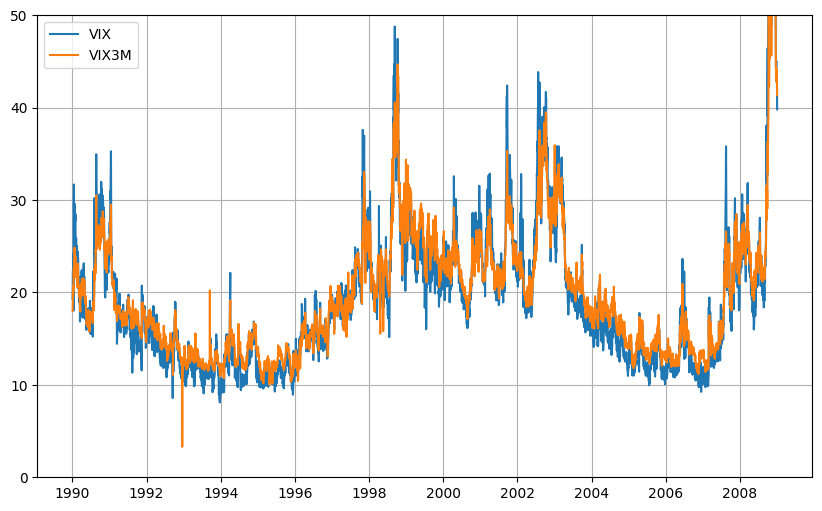

In [64]:
plot_graph_rep_var(pro_dict)

Now to load it up against the SP500 data earlier to see how it coincides.

We will truncate the data at 2009, which is the last point of the analysis.

Data beyond 2009 gets exponentially larger as more and more option chains are added (eg weeklys)

In [50]:
temp = mez_dict_var(pro_dict, 43200)
temp_2 = mez_dict_var(pro_dict, 93*24*60)

act_vix['cal_VIX']= act_vix['date_dt'].map(temp)
act_vix['cal_VIX_3M']= act_vix['date_dt'].map(temp_2)

act_vix['inverted'] = np.where(act_vix['cal_VIX'] > act_vix['cal_VIX_3M'], 1, 0)

merged_df_calc = pd.merge(act_sp500,act_vix, on = 'date_dt')

merged_df_calc = merged_df_calc[merged_df_calc['cal_VIX'].notnull()]

merged_df_calc["percent_change"]= merged_df_calc['change'] + 1

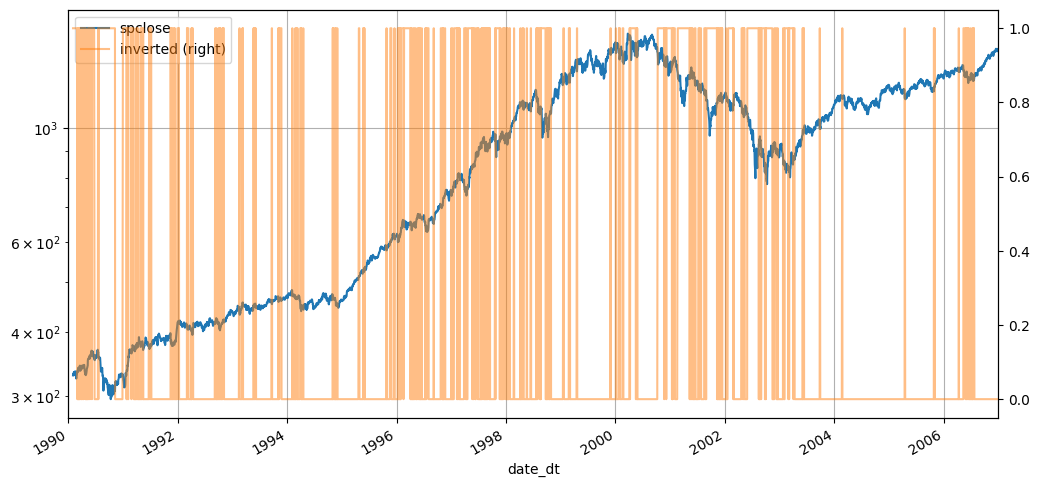

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))
merged_df_calc.plot('date_dt', 'spclose', logy = True, grid = True, ax=ax)
merged_df_calc.plot('date_dt', ['inverted'], secondary_y=True, ax=ax, alpha = 0.5)
start_date = pd.Timestamp('1990-01-01')
end_date = pd.Timestamp('2006-12-31')
ax.set_xlim(start_date, end_date)

plt.show()

Lets get the properties of the data

In [52]:
merged_gby_calc = merged_df_calc.groupby('inverted')

In [53]:
merged_gby_calc['sp_local_low'].value_counts()

inverted  sp_local_low
0         0               3410
          1                 93
1         0               1190
          1                 75
Name: count, dtype: int64

In [54]:
merged_gby_calc['sp_local_high'].value_counts()

inverted  sp_local_high
0         0                3370
          1                 133
1         0                1237
          1                  28
Name: count, dtype: int64

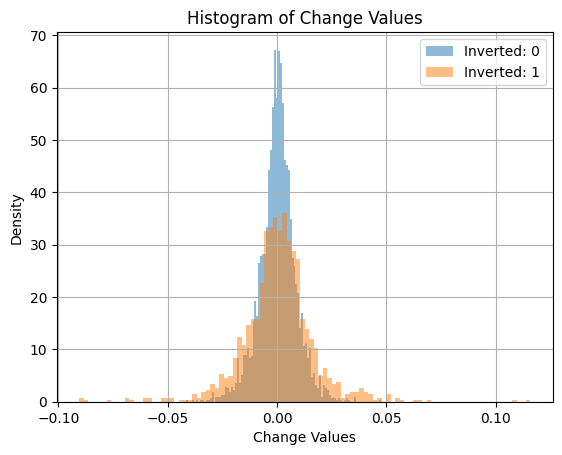

In [55]:
#merged_gby_calc.change.hist(density = True, grid=True, bins =100, alpha = 0.5)
fig, ax = plt.subplots()

for name, group in merged_gby_calc:
    group['change'].hist(density=True, grid=True, bins=100, alpha=0.5, label=f'Inverted: {name}', ax=ax)

# Customize your plot (labels, title, etc.)
ax.set_xlabel('Change Values')
ax.set_ylabel('Density')
ax.set_title('Histogram of Change Values')
ax.legend()

# Show the plot
plt.show()

In [101]:
merged_gby_calc['percent_change'].apply(stats.gmean)

inverted
0    1.000157
1    1.000389
Name: percent_change, dtype: float64

In [102]:
merged_gby_calc['change'].mean()

inverted
0    0.000193
1    0.000533
Name: change, dtype: float64

In [103]:
merged_gby_calc['change'].var()

inverted
0    0.000073
1    0.000287
Name: change, dtype: float64

In [104]:
merged_gby_calc['change'].skew()

inverted
0   -0.148464
1   -0.002582
Name: change, dtype: float64

At this juncture, we can see that the 'inverted' relationship continues to affect the distribution of forward SP500 returns

However, the case is not as clear cut from 1990 - 2006 as is from 2007 - 2023.

A visual inspection of the chart versus the underlying SP500 gives a quick reasoning

Normally as the SP500 goes up, volatility tends to trend downwards.

We can see this clearly in the 1991 - 1995, 2003-2007, 2010-2015, 2016-2019, and 2020-2022 bull markets

However, from 1996 - 1998, we have an issue of SP500 going up and VIX trending up as well.

Lets take a closer look at the 1990s.

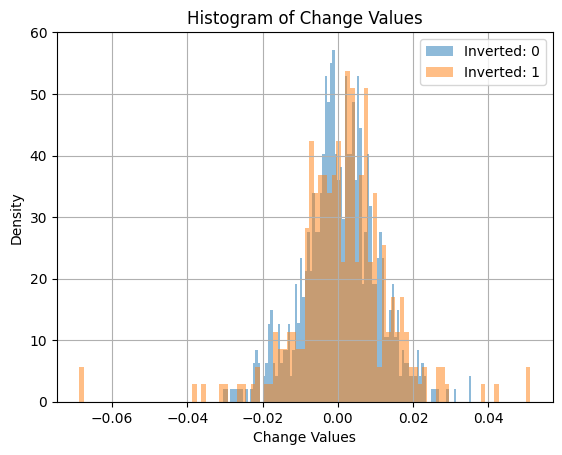

In [56]:
merged_df_calc['year'] = merged_df_calc['date_dt'].dt.year  
filtered_df_1996 = merged_df_calc[(merged_df_calc['year'] >= 1996) & (merged_df_calc['year'] <= 1999)]
merged_gby_calc_1996 = filtered_df_1996.groupby('inverted')

#merged_gby_calc_1996.change.hist(density = True, grid=True, bins =100, alpha = 0.5)

fig, ax = plt.subplots()

for name, group in merged_gby_calc_1996:
    group['change'].hist(density=True, grid=True, bins=100, alpha=0.5, label=f'Inverted: {name}', ax=ax)

# Customize your plot (labels, title, etc.)
ax.set_xlabel('Change Values')
ax.set_ylabel('Density')
ax.set_title('Histogram of Change Values')
ax.legend()

# Show the plot
plt.show()

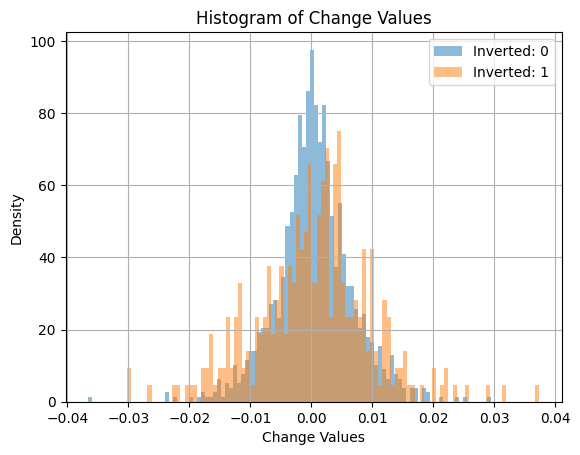

In [57]:
#merged_df_calc['year'] = merged_df_calc['date_dt'].dt.year  
filtered_df_1990 = merged_df_calc[(merged_df_calc['year'] <= 1995)]
merged_gby_calc_1990 = filtered_df_1990.groupby('inverted')

#merged_gby_calc_1990.change.hist(density = True, grid=True, bins =100, alpha = 0.5)
fig, ax = plt.subplots()

for name, group in merged_gby_calc_1990:
    group['change'].hist(density=True, grid=True, bins=100, alpha=0.5, label=f'Inverted: {name}', ax=ax)

# Customize your plot (labels, title, etc.)
ax.set_xlabel('Change Values')
ax.set_ylabel('Density')
ax.set_title('Histogram of Change Values')
ax.legend()

# Show the plot
plt.show()

There is quite a bit of visual evidence that the inversion is not a good distinguishing feature from 1996-1999.

Whereas, from 1990-1995, it seems closer to the trends observed post 2003.

It is not clear why in a bull market, did option prices go up in general.

One could do a regression against realised volatility to gain an understanding if the market markers had to increase prices due to realised volatility.

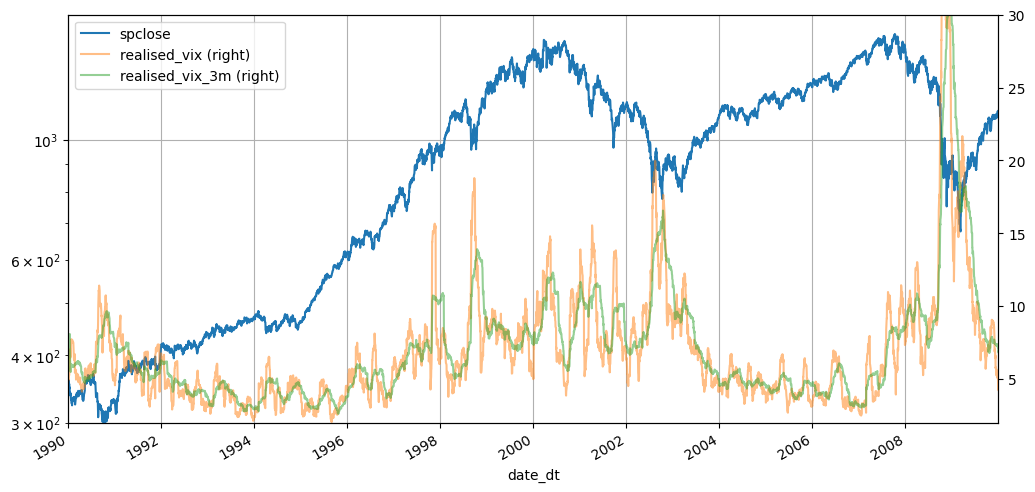

In [53]:
fig, ax = plt.subplots(figsize=(12, 6))
act_sp500.plot('date_dt', 'spclose', logy=True, grid=True, ax=ax)
act_sp500.plot('date_dt', ['realised_vix','realised_vix_3m'], secondary_y=True, ax=ax, alpha=0.5)
start_date = pd.Timestamp('1990-01-01')
end_date = pd.Timestamp('2009-12-31')
ax.set_xlim(start_date, end_date)
ax.set_ylim(300, 1700)
ax.right_ax.set_ylim(2, 30)
plt.show()

It requires some eyeballing effort, but there is a clear trend of rising realised volatility from 1996 onward.

Is this the only answer? Market markers will on average need a premium of implied vs realised to make money when hedging costs are calculated.

VIX is also a variance swap translated into volatility points, so it doesn't fully capture the option picture.

Perhaps market structure within the option chains changed as well - volatility skews could have become smiles if call upside needed to be increased by market makers in view of the sustained bull run.

However it doesn't answer what factors drove the volatility increase.

During the period in question, the Asian Financial Crisis, Russian debt default, and LTCM events occured.These are signficant events but they all ended by 1998. 

However in 1999-early 2000, there should have been more of a drop in realised volatility, which is a dissatisfing answer.

This area does merit more investigation. 

# Conclusion

The VIX - VIX3M relation gives strong indications of regime change in the underlying, SPX. 

For a simple case of binary measures (VIX>VIX3M), publicly available information from CBOE supports this.

Computations from scratch of non-publically available option prices show that similiar trends exist prior to 2007.

However, other unseen factors from 1996-1999 caused the unusual relationship of rising vol + rising markets. 

More work is needed to determine this factor before any trading strategy can be developed. 